<a href="https://colab.research.google.com/github/WeiHao97/Security_SysML/blob/main/Quantization_Pytorch_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Workspace from Google Drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Create a link in VM from G drive and then do processing in local workfolder 

In [ ]:
!ls /content/drive/MyDrive/QuantizedRobustNN


In [ ]:
!ln -s /content/drive/MyDrive/QuantizedRobustNN    /content/my_workspace

In [ ]:
!cd /content/my_workspace/ && ls -l

In [ ]:
WORKSPACE="/content/my_workspace/"
print(WORKSPACE)

In [ ]:
!nvidia-smi

### End Google Drive Usage and unmount


In [ ]:
# drive.flush_and_unmount()
# print('All changes made in this colab session should now be visible in Drive.')

# Load Framework

In [ ]:
import os
import sys
import time
import torch
import random
import numpy as np
import pandas as pd

import tensorboard
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from pathlib import Path
from torchvision import datasets, models, transforms



# Model 

In [ ]:
torch.cuda.is_available()

In [ ]:
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True)

In [ ]:
print(vgg16)

In [ ]:
vgg16.eval()

# *Quantization

In [ ]:
!uname -m
#### Use server archtitecture

In [ ]:
import torch.quantization
torch.backends.quantized.engine = 'fbgemm'


##### 1. for post training quantization (static) <----
vgg16.qconfig = torch.quantization.get_default_qconfig('fbgemm')

##### 2. for quantization aware training (QAT). 
# qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')



In [ ]:
# Prepare the model for static quantization. This inserts observers in
# the model that will observe activation tensors during calibration.
vgg_prepared = torch.quantization.prepare(vgg16 , inplace=True)


In [ ]:
# calibrate the prepared model to determine quantization parameters for activations
# in a real world setting, the calibration would be done with a representative dataset
input_fp32 = torch.randn(1, 3, 224, 224)
vgg_prepared(input_fp32)
# Convert the observed model to a quantized model. This does several things:
# quantizes the weights, computes and stores the scale and bias value to be
# used with each activation tensor, and replaces key operators with quantized
# implementations.
vgg16_int8 = torch.quantization.convert(vgg_prepared)

In [ ]:
vgg16_int8

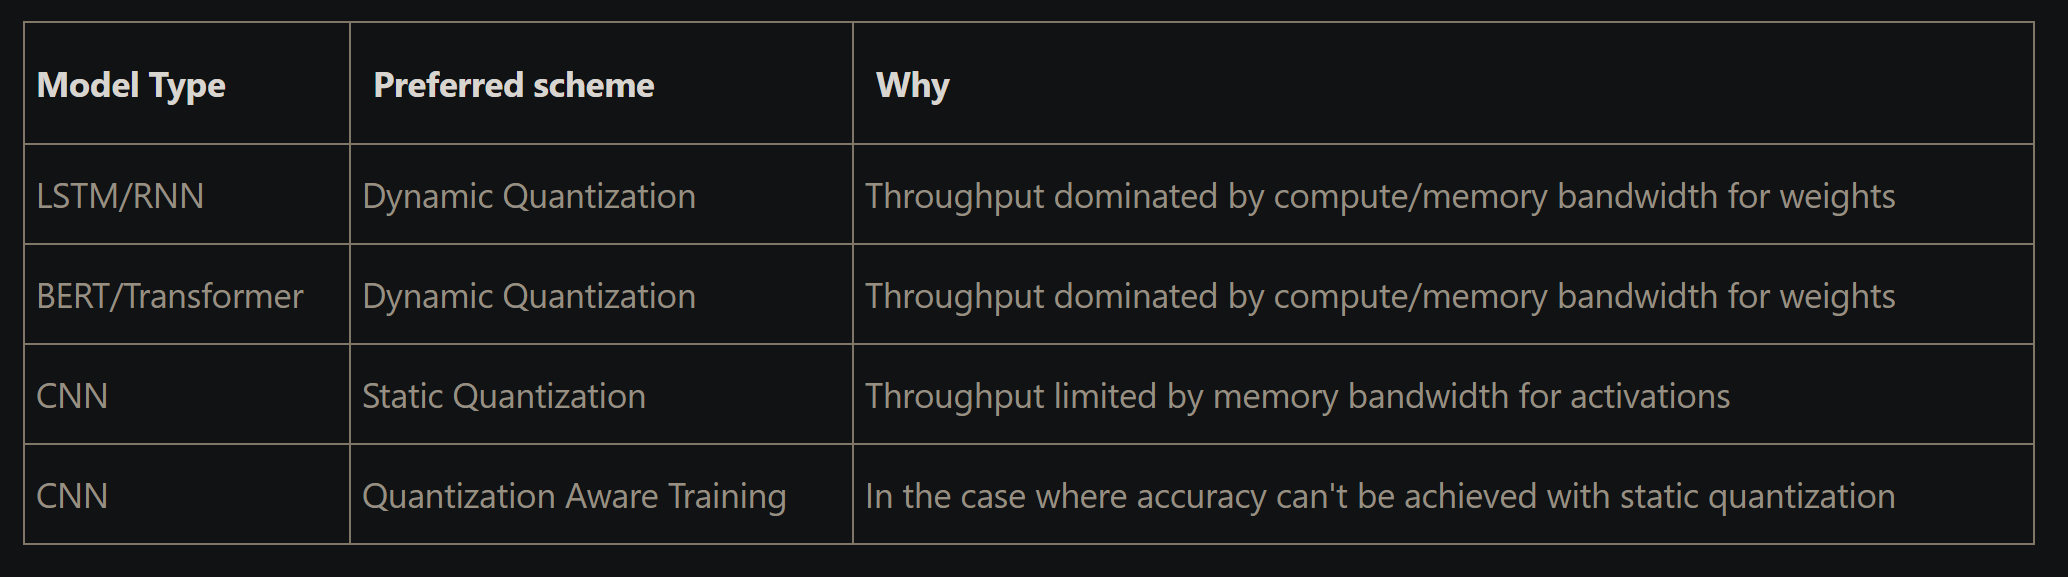

In [ ]:
# vgg_prepared(input_fp32)
input_fp32.size()

# Load Dataset

##  1. Imagenet (Tiny)

In [ ]:
! git clone https://github.com/seshuad/IMagenet Imagenet
! ls 'Imagenet/tiny-imagenet-200/'

In [ ]:
BATCH_SIZE = 4

In [ ]:
data_dir = '/content/Imagenet/tiny-imagenet-200/'


# Data augmentation and normalization for training
# Just normalization for validation
data_transforms= {
    'train': transforms.Compose([
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, 
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val','test']}

            
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

# Model Evaluation 

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

In [ ]:
model = vgg16

In [ ]:
def test_model(model, dataloaders, dataset_sizes, criterion, optimizer):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    since = time.time()

    # Each epoch has a training and validation phase
    for phase in ['test']:
        model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i,(inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            print("\rIteration: {}/{}, Loss: {}.".format(i+1, len(dataloaders[phase]), loss.item() * inputs.size(0)), end="")
            sys.stdout.flush()


        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
    print()
    print('Test Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    print()
    
    time_elapsed = time.time() - since
    print('Test complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

In [ ]:
def predict_image(model , image):
    image_tensor = data_transforms['val'](image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    # Turn the input into a Variable
    input = Variable(image_tensor)
    input = input.to(device)
    print(input)
    output = model(input)
    print(output)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=data_transforms['val'])
    classes = class_names
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [ ]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(BATCH_SIZE)
fig=plt.figure(figsize=(10,10))

for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(model, image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    # sub.set_title(str(class_names[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

# Start Training

### Train!

In [ ]:
%load_ext tensorboard
import datetime
import os
from torch.utils.tensorboard import SummaryWriter

In [ ]:
model_name = ""
FOLDER_NAME="training_results/" 

MODEL_DIR = "/content/my_workspace/" + FOLDER_NAME  + model_name
LOGDIR = MODEL_DIR  + "/runs/"

print("Current Log Directory => " +  LOGDIR)
print("MODEL_DIR: " + MODEL_DIR)
os.makedirs(  LOGDIR  + datetime.datetime.now().strftime("%Y%m%d-%H%M"))

tb = SummaryWriter(log_dir = LOGDIR  + datetime.datetime.now().strftime("%Y%m%d-%H%M/") )


# load previous best model params if exists
saved_model_path = MODEL_DIR   +  ".pt"
print("saved model path: " + saved_model_path)



In [ ]:
print(LOGDIR  + datetime.datetime.now().strftime("%Y%m%d-%H%M/"))

In [ ]:
%tensorboard --logdir $LOGDIR

In [ ]:
LAST_COMPLETED_EPOCH = 0  

N_EPOCHES = 100


%tensorboard --logdir $LOGDIR

if os.path.isfile(saved_model_path):
    model.load_state_dict(torch.load(saved_model_path))
    print("successfully load previous best model parameters")
else:
    print("Error: can't load previous param")



for epoch in range(LAST_COMPLETED_EPOCH, N_EPOCHES):
    print("Epoch {} ...".format(epoch + 1))
    start_time = time.time()
    print("Start training ...")
    train_loss = train(model, train_loader, optimizer, criterion)

    tb.add_scalar('Loss/training', train_loss / BATCH_SIZE , epoch )  ############

    print("Start evaluating")
    val_loss = evaluate(model, val_loader, criterion)

    tb.add_scalar("Loss/validation ", val_loss / (BATCH_SIZE *2) , epoch )  ###########
  

    end_time = time.time()
    mins, secs = epoch_time(start_time, end_time)
    print(F'Epoch: {epoch+1:02} | Time: {mins}m {secs}s')
    print(F'\tTrain Loss: {train_loss:.3f}')
    print(F'\t Val. Loss: {val_loss:.3f}')

    tb.flush()

    if val_loss < prev_val_loss:
      print("saving current model")
      os.makedirs(MODEL_DIR, exist_ok=True)
      torch.save(model.state_dict(), saved_model_path)
    
      

tb.flush()

while True:pass  # to keep this cell from disconnecting

In [ ]:
tb.close()

In [ ]:
from google.colab import files


!zip -r /content/runs.zip $LOGDIR
files.download('/content/runs.zip') 